In [1]:
import re
from collections import defaultdict

# import the libraries needed

from pydriller import Repository
from pydriller.domain.commit import ModificationType, Commit
import pandas as pd

In [2]:
# set the repository path
repository_path = "hadoop"
# to use remote repo uncomment the following:
# repository_path = "https://github.com/apache/hadoop"

In [3]:
# set the Excel file path
excel_filename = "Issues_assignment1.xlsx"
excel_sheet = "Group3"

In [4]:
def get_commit_keys(filename: str, sheet_name: str) -> list:
    df = pd.read_excel(filename, sheet_name = sheet_name)
    
    keys = df["Key"].tolist()
    return keys

In [5]:
def get_repository(path: str):
    return Repository(path)

In [6]:
def analyze_commit_file_level(data: Commit):
    modified_files: list[dict[str, str|int|None]] = []
    '''
        {
            'CommitHash': 'jchejfvgdbsnma',
            'FileName': 'abc.java',
            'ChangeType: 'Add',
            'TotalAddedLines': 1,
            'TotalDeletedLines': 0,
            'Complexity': 1.2
        }
    '''
    for modified_file in data.modified_files:
        
        added_methods = deleted_methods = modified_methods = 0
        
        total_methods_before = len(modified_file.methods_before)
        total_methods_after = len(modified_file.methods)
        total_changed_methods = len(modified_file.changed_methods)
        
        if total_methods_before < total_methods_after:
            added_methods = total_methods_after - total_methods_before
            deleted_methods = 0
            modified_methods = total_changed_methods - added_methods
        else:
            added_methods = 0
            deleted_methods = total_methods_before - total_methods_after
            modified_methods = total_changed_methods - deleted_methods
        
        row = {
            'CommitHash': commit.hash,
            'FileName': modified_file.filename,
            'ChangeType': modified_file.change_type,
            'AddedLines': modified_file.added_lines,
            'DeletedLines': modified_file.deleted_lines,
            'AddedMethods': added_methods,
            'DeletedMethods': deleted_methods,
            'ModifiedMethods': modified_methods,
            'Complexity': modified_file.complexity,
        }
        modified_files.append(row)
    
    return modified_files
        

In [7]:
def analyze_commit(data: Commit):
    
    # Initialize counters
    added_files = modified_files = deleted_files = 0
    
    # Analyze modifications in each commit
    for modified_file in data.modified_files:
        # count number of files added/removed/modified.
        if modified_file.change_type == ModificationType.ADD:
            added_files += 1
        elif modified_file.change_type == ModificationType.MODIFY:
            modified_files += 1
        elif modified_file.change_type == ModificationType.DELETE:
            deleted_files += 1
        
    return {
        'CommitHash': commit.hash,
        'Author': f"{commit.author.name} <{commit.author.email}>",
        'CommitDate': commit.committer_date,
        'Message': commit.msg,
        'TotalAddedFiles': added_files,
        'TotalModifiedFiles': modified_files,
        'TotalDeletedFiles': deleted_files,
        'UnitSize': data.dmm_unit_size,
        'Complexity': data.dmm_unit_complexity,
        'Interfacing': data.dmm_unit_interfacing,
    }

In [8]:
repository = get_repository(repository_path)
commits = repository.traverse_commits()
issued_keys = get_commit_keys(excel_filename, excel_sheet)

# I used set to avoid duplicates
issued_commits: set[Commit] = set()
for commit in commits:
    if any(commit.msg.__contains__(key) for key in issued_keys):
        issued_commits.add(commit)

# multiple commits can be linked to the same issue_key
print("Found issued commits: " + len(issued_commits).__str__());

Found issued commits: 525


In [9]:
# let's filter the issued_commits to check if there was design change
# feel free to update the regex pattern
design_issue_pattern = r'\b(design|architecture|pattern|fix|refactor)\b'

filtered_commits: set[Commit] = set()
for commit in issued_commits:
    if re.search(design_issue_pattern, commit.msg.lower()):
        filtered_commits.add(commit)

print("Found commits with filter issues: " + len(filtered_commits).__str__())

Found commits with filter issues: 38


In [10]:
# stores filtered_commit with their parents
commit_dict: dict[Commit, set[Commit]] = defaultdict(set)

for filtered_commit in filtered_commits:
    parent_commit_hashes = filtered_commit.parents
    # print(parent_commit_hashes)
    
    parent_commits: set[Commit] = set()
    for commit in repository.traverse_commits():
        # print(commit.hash)
        if any(commit.hash.__eq__(hash) for hash in parent_commit_hashes):
            parent_commits.add(commit)
            
    commit_dict[filtered_commit] = parent_commits     
    
# this one takes sometime

In [11]:
issued_commits_and_parent_mapping_rows: list[dict[str, str]] = []
commit_details_list: list[dict[str, str]] = []
file_details_list = []

for key, value in commit_dict.items():
    for commit in value:
        row = {
            'CommitHash': key.hash,
            'ParentCommitHash': commit.hash,
        }
        
        issued_commits_and_parent_mapping_rows.append(row)
        commit_details_list.append(analyze_commit(commit))
        file_details_list.extend(analyze_commit_file_level(commit))

# a commit can have multiple parents
issued_commits_and_parent_mapping = pd.DataFrame(issued_commits_and_parent_mapping_rows)
issued_commits_and_parent_mapping.head(10)

# contains details on file level

,CommitHash,ParentCommitHash
0,3a0b84d9c994f9a634b32903e5c1876c44f8c16e,6814324c332a7d780f3b844fd6f1c62db2f6c88e
1,3c83cee118137e3d5bbe0c942e92e179d1234d5b,1ba31fe9e906dbd093afd4b254216601967a4a7b
2,e2f640942b722e35490cf146c0268517da5a28b1,c77a1095dc556e8bea87df6d8ddf36e898f27e86
3,74a4cc56e8f5084e621b279b2fcdf27c690cff7b,244380a885f5cd009fa16cb9a6774337eab52e1d
4,19639785f5e9c483558ce585287b9dda9d626263,12b11e2e688158404feeb3ded37eb6cccad4ea5c
5,c023c748869063fb67d14ea996569c42578d1cea,bedfec0c10144087168bc79501ffd5ab4fa52606
6,7bd5d4272cd686e06c5d5fcc489b69312dacb47b,c447efebdb92dcdf3d95e983036f53bfbed2c0b4
7,1e7ce76bbab08a153b285739de51c3de924e3580,9aaa714a999f998b6acc9904beb414d327c06f8b
8,01d81f4e51c64d5b316d129b514fa6802770ead9,c984f6c77e31cc288a131d877bfca9434e51fc68
9,a703dae25e3c75a4e6086efd4b620ef956e6fe54,e1c5ddf2aa854951142e234462978245cdb99e1d


In [28]:
# contains details on commit level
commit_details = pd.DataFrame(commit_details_list)
print(len(commit_details_list))
commit_details.head(len(commit_details_list))

38


,CommitHash,Author,CommitDate,Message,TotalAddedFiles,TotalModifiedFiles,TotalDeletedFiles,UnitSize,Complexity,Interfacing
0,6814324c332a7d780f3b844fd6f1c62db2f6c88e,Haohui Mai <wheat9@apache.org>,2017-08-01 18:34:07-07:00,HDFS-12107. FsDatasetImpl#removeVolumes floods...,0,1,0,NaN,NaN,NaN
1,1ba31fe9e906dbd093afd4b254216601967a4a7b,Jason Lowe <jlowe@apache.org>,2016-05-25 21:24:55+00:00,YARN-4459. container-executor should only kill...,0,2,0,1.000000,1.000000,0.173077
2,c77a1095dc556e8bea87df6d8ddf36e898f27e86,Wangda Tan <wangda@apache.org>,2016-06-14 15:06:38-07:00,YARN-1942. Deprecate toString/fromString metho...,0,105,0,1.000000,0.500000,0.050000
3,244380a885f5cd009fa16cb9a6774337eab52e1d,Giridharan Kesavan <gkesavan@apache.org>,2009-06-02 09:11:13+00:00,Fix core test failrues \n\ngit-svn-id: https:/...,0,3,0,NaN,NaN,NaN
4,12b11e2e688158404feeb3ded37eb6cccad4ea5c,Wangda Tan <wangda@apache.org>,2016-03-31 14:35:18-07:00,YARN-4634. Scheduler UI/Metrics need to consid...,0,1,0,0.000000,0.000000,1.000000
5,bedfec0c10144087168bc79501ffd5ab4fa52606,Akira Ajisaka <aajisaka@apache.org>,2016-10-18 15:00:44+09:00,HADOOP-13522. Add %A and %a formats for fs -st...,0,5,0,0.217391,0.739130,1.000000
6,c447efebdb92dcdf3d95e983036f53bfbed2c0b4,Jitendra Pandey <jitendra@apache.org>,2016-07-11 14:55:33-07:00,HDFS-10579. HDFS web interfaces lack configs f...,2,4,0,0.683673,0.857143,0.928571
7,9aaa714a999f998b6acc9904beb414d327c06f8b,Owen O'Malley <omalley@apache.org>,2014-07-17 17:45:12+00:00,HADOOP-10732. Fix locking in credential update...,0,2,0,0.000000,1.000000,1.000000
8,c984f6c77e31cc288a131d877bfca9434e51fc68,Giridharan Kesavan <gkesavan@apache.org>,2009-06-01 06:11:05+00:00,Fix jdiff and javadoc target\n\ngit-svn-id: ht...,1,1,0,NaN,NaN,NaN
9,e1c5ddf2aa854951142e234462978245cdb99e1d,Ben Roling <ben.roling@gmail.com>,2019-04-24 14:55:58+01:00,HADOOP-16252. Add prefix to dynamo tables in t...,0,8,0,0.550000,0.800000,1.000000


In [13]:
file_details = pd.DataFrame(file_details_list)
file_details.head(10)

,CommitHash,FileName,ChangeType,AddedLines,DeletedLines,AddedMethods,DeletedMethods,ModifiedMethods,Complexity
0,6814324c332a7d780f3b844fd6f1c62db2f6c88e,FsDatasetImpl.java,ModificationType.MODIFY,1,1,0,0,1,459.0
1,1ba31fe9e906dbd093afd4b254216601967a4a7b,container-executor.c,ModificationType.MODIFY,5,14,0,0,1,328.0
2,1ba31fe9e906dbd093afd4b254216601967a4a7b,test-container-executor.c,ModificationType.MODIFY,0,49,0,1,1,145.0
3,c77a1095dc556e8bea87df6d8ddf36e898f27e86,YarnChild.java,ModificationType.MODIFY,5,5,0,0,1,29.0
4,c77a1095dc556e8bea87df6d8ddf36e898f27e86,MRAppMaster.java,ModificationType.MODIFY,1,1,0,0,1,208.0
5,c77a1095dc556e8bea87df6d8ddf36e898f27e86,TaskAttemptImpl.java,ModificationType.MODIFY,3,4,0,0,2,196.0
6,c77a1095dc556e8bea87df6d8ddf36e898f27e86,TaskAttemptInfo.java,ModificationType.MODIFY,3,1,0,0,1,17.0
7,c77a1095dc556e8bea87df6d8ddf36e898f27e86,MRApp.java,ModificationType.MODIFY,1,1,0,0,1,84.0
8,c77a1095dc556e8bea87df6d8ddf36e898f27e86,TestMRAppMaster.java,ModificationType.MODIFY,33,33,0,0,9,41.0
9,c77a1095dc556e8bea87df6d8ddf36e898f27e86,TestCommitterEventHandler.java,ModificationType.MODIFY,6,6,0,0,3,24.0


Index(['CommitHash', 'Author', 'CommitDate', 'Message', 'TotalAddedFiles',
       'TotalModifiedFiles', 'TotalDeletedFiles', 'UnitSize', 'Complexity',
       'Interfacing'],
      dtype='object')


<Axes: title={'center': 'Message'}, xlabel='TotalAddedFiles'>

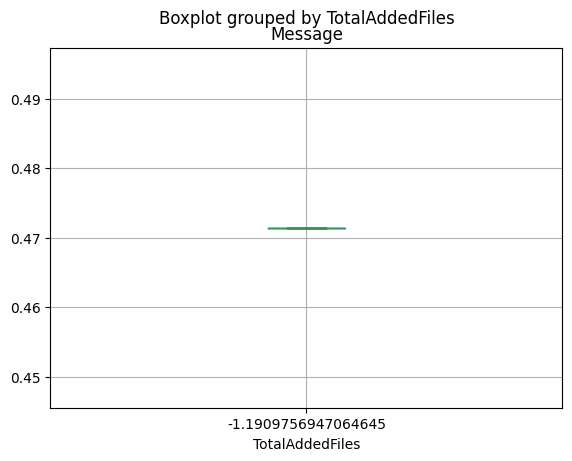

In [14]:
import matplotlib.pyplot as plt
import numpy as np

print(commit_details.columns)
# Assuming commit_details is your DataFrame
# Assuming commit_details is your DataFrame
np.random.seed(1234)
commit_details = pd.DataFrame(np.random.randn(1, 2),
                              columns=['Message', 'TotalAddedFiles'])

# Now, you can create the boxplot for 'Message' and 'TotalAddedFiles' columns
commit_details.boxplot(column=[ 'Message'], by='TotalAddedFiles',)


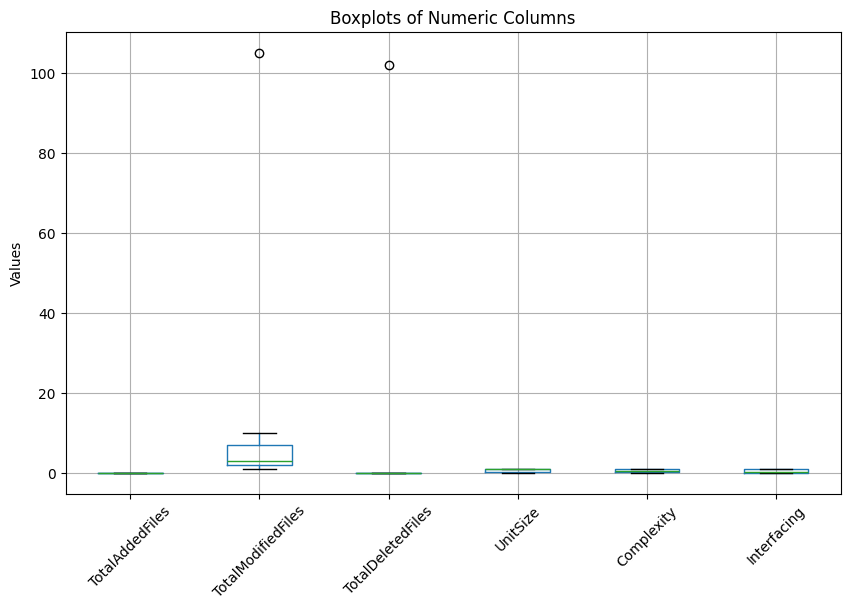

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have your data in a pandas DataFrame
# If not, you can create one from your data
data = {
    'id': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13'],
    'author': ['Haohui Mai', 'Giridharan Kesavan', 'Michael Stack', 'Chris Douglas', 'Jian He', 
               'Ashutosh Gupta', 'Ayush Saxena', 'Thomas White', 'Kihwal Lee', 'Wangda Tan', 
               'Yuming Wang', 'PJ Fanning', 'Giridharan Kesavan', None],
    'date': ['2017-08-01 18:34:07-07:00', '2009-05-28 14:55:35+00:00', '2011-06-02 18:56:32+00:00', 
             '2016-10-28 16:49:36-07:00', '2017-08-02 00:03:25-07:00', '2022-05-17 20:34:12+01:00', 
             '2019-07-30 22:17:39+05:30', '2010-03-10 20:06:07+00:00', '2013-07-01 20:20:27+00:00', 
             '2016-06-14 15:06:38-07:00', '2019-10-18 08:25:02-07:00', '2023-03-13 10:08:04+05:30', 
             '2009-06-01 09:54:21+00:00', None],
    'message': ['HDFS-12107. FsDatasetImpl#removeVolumes floods...', 'fixed test test-core and test-contrib targets...',
                'HADOOP-7351 Regression: HttpServer#getWebAppsP...', 'YARN-3460. TestSecureRMRegistryOperations fail...',
                'YARN-6872. [Addendum patch] Ensure apps could ...', 'HADOOP-18237. Upgrade Apache Xerces Java to 2....',
                'HDFS-14677. TestDataNodeHotSwapVolumes#testAdd...', 'HADOOP-6504. Invalid example in the documentat...',
                'HDFS-4888. Refactor and fix FSNamesystem.getTu...', 'YARN-1942. Deprecate toString/fromString metho...',
                'HADOOP-16152. Upgrade Eclipse Jetty version to...', 'HADOOP-18658. snakeyaml dependency: upgrade to...',
                'To fix test targets\n\ngit-svn-id: https://svn...', None],
    'TotalAddedFiles': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, None],
    'TotalModifiedFiles': [1, 1, 2, 3, 3, 1, 1, 2, 4, 105, 10, 2, 1, None],
    'TotalDeletedFiles': [0, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, None],
    'UnitSize': [None, 0.562509, None, 0.0, 1.0, None, 0.0, None, 1.0, 1.0, 1.0, None, None, None],
    'Complexity': [None, 0.210051, None, 1.0, 0.0, None, 0.0, None, 1.0, 0.5, 1.0, None, None, None],
    'Interfacing': [None, 0.089552, None, 1.0, 0.0, None, 1.0, None, 0.0, 0.05, 1.0, None, None, None]
}

df = pd.DataFrame(data)

# Drop rows with None values
df.dropna(inplace=True)

# Convert columns to numeric if needed
numeric_cols = ['TotalAddedFiles', 'TotalModifiedFiles', 'TotalDeletedFiles', 'UnitSize', 'Complexity', 'Interfacing']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric)

# Create boxplots
plt.figure(figsize=(10, 6))
df.boxplot(column=numeric_cols)
plt.title('Boxplots of Numeric Columns')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.show()


Index(['Message', 'TotalAddedFiles'], dtype='object')


<Axes: title={'center': 'Message'}, xlabel='TotalAddedFiles'>

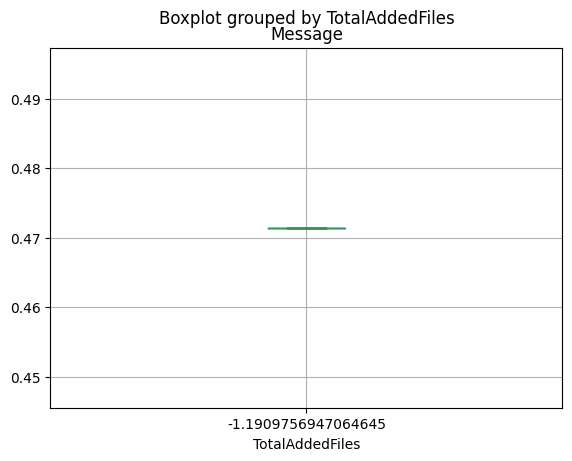

In [16]:
import matplotlib.pyplot as plt
import numpy as np

print(commit_details.columns)
# Assuming commit_details is your DataFrame
# Assuming commit_details is your DataFrame
np.random.seed(1234)
commit_details = pd.DataFrame(np.random.randn(1, 2),
                              columns=['Message', 'TotalAddedFiles'])

# Now, you can create the boxplot for 'Message' and 'TotalAddedFiles' columns
commit_details.boxplot(column=[ 'Message'], by='TotalAddedFiles',)


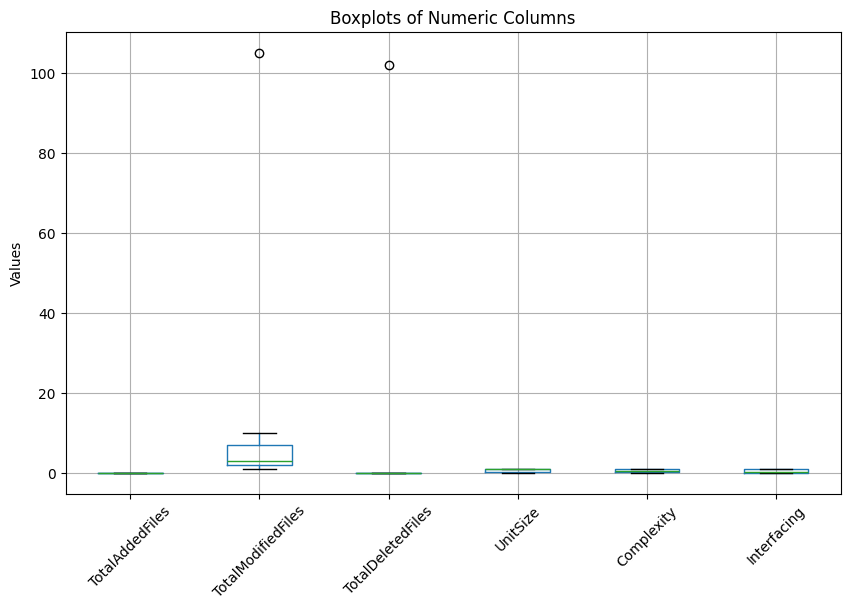

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have your data in a pandas DataFrame
# If not, you can create one from your data
data = {
    'id': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13'],
    'author': ['Haohui Mai', 'Giridharan Kesavan', 'Michael Stack', 'Chris Douglas', 'Jian He', 
               'Ashutosh Gupta', 'Ayush Saxena', 'Thomas White', 'Kihwal Lee', 'Wangda Tan', 
               'Yuming Wang', 'PJ Fanning', 'Giridharan Kesavan', None],
    'date': ['2017-08-01 18:34:07-07:00', '2009-05-28 14:55:35+00:00', '2011-06-02 18:56:32+00:00', 
             '2016-10-28 16:49:36-07:00', '2017-08-02 00:03:25-07:00', '2022-05-17 20:34:12+01:00', 
             '2019-07-30 22:17:39+05:30', '2010-03-10 20:06:07+00:00', '2013-07-01 20:20:27+00:00', 
             '2016-06-14 15:06:38-07:00', '2019-10-18 08:25:02-07:00', '2023-03-13 10:08:04+05:30', 
             '2009-06-01 09:54:21+00:00', None],
    'message': ['HDFS-12107. FsDatasetImpl#removeVolumes floods...', 'fixed test test-core and test-contrib targets...',
                'HADOOP-7351 Regression: HttpServer#getWebAppsP...', 'YARN-3460. TestSecureRMRegistryOperations fail...',
                'YARN-6872. [Addendum patch] Ensure apps could ...', 'HADOOP-18237. Upgrade Apache Xerces Java to 2....',
                'HDFS-14677. TestDataNodeHotSwapVolumes#testAdd...', 'HADOOP-6504. Invalid example in the documentat...',
                'HDFS-4888. Refactor and fix FSNamesystem.getTu...', 'YARN-1942. Deprecate toString/fromString metho...',
                'HADOOP-16152. Upgrade Eclipse Jetty version to...', 'HADOOP-18658. snakeyaml dependency: upgrade to...',
                'To fix test targets\n\ngit-svn-id: https://svn...', None],
    'TotalAddedFiles': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, None],
    'TotalModifiedFiles': [1, 1, 2, 3, 3, 1, 1, 2, 4, 105, 10, 2, 1, None],
    'TotalDeletedFiles': [0, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, None],
    'UnitSize': [None, 0.562509, None, 0.0, 1.0, None, 0.0, None, 1.0, 1.0, 1.0, None, None, None],
    'Complexity': [None, 0.210051, None, 1.0, 0.0, None, 0.0, None, 1.0, 0.5, 1.0, None, None, None],
    'Interfacing': [None, 0.089552, None, 1.0, 0.0, None, 1.0, None, 0.0, 0.05, 1.0, None, None, None]
}

df = pd.DataFrame(data)

# Drop rows with None values
df.dropna(inplace=True)

# Convert columns to numeric if needed
numeric_cols = ['TotalAddedFiles', 'TotalModifiedFiles', 'TotalDeletedFiles', 'UnitSize', 'Complexity', 'Interfacing']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric)

# Create boxplots
plt.figure(figsize=(10, 6))
df.boxplot(column=numeric_cols)
plt.title('Boxplots of Numeric Columns')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.show()



<>:15: SyntaxWarning: invalid escape sequence '\.'
<>:15: SyntaxWarning: invalid escape sequence '\.'
/var/folders/y4/17vfpymx38nd0dxshk86jrvw0000gn/T/ipykernel_45041/2021350674.py:15: SyntaxWarning: invalid escape sequence '\.'
  'HADOOP-6155. Deprecate RecordIO anticipating A...', 'fixed test test-core and test-contrib targets\...',


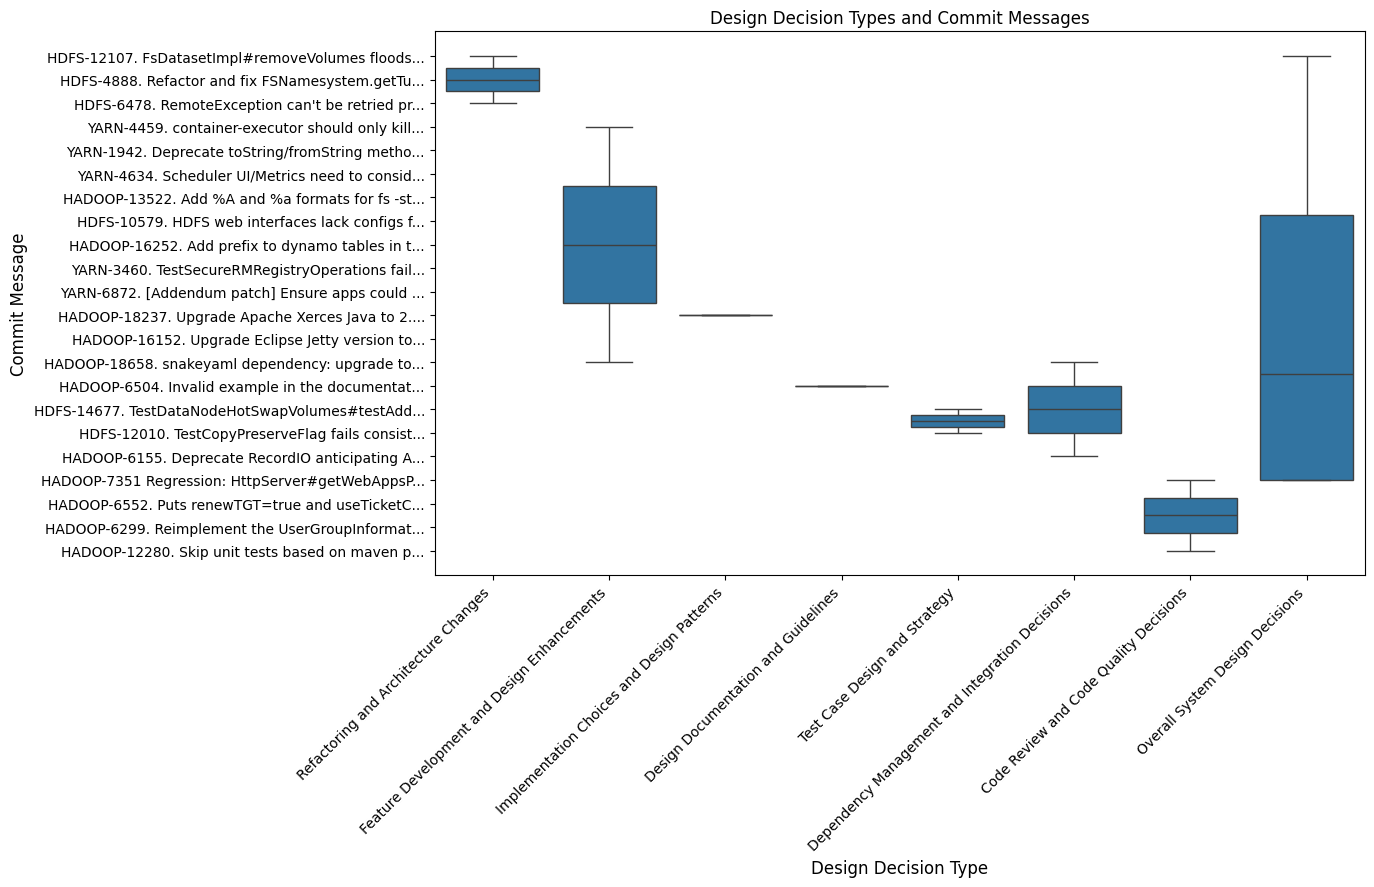

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = {
    'message': ['HDFS-12107. FsDatasetImpl#removeVolumes floods...', 'YARN-4459. container-executor should only kill...',
                'YARN-1942. Deprecate toString/fromString metho...', 'Fix core test failrues \n\ngit-svn-id: https:/...',
                'YARN-4634. Scheduler UI/Metrics need to consid...', 'HADOOP-13522. Add %A and %a formats for fs -st...',
                'HDFS-10579. HDFS web interfaces lack configs f...', 'HADOOP-10732. Fix locking in credential update...',
                'Fix jdiff and javadoc target\n\ngit-svn-id: ht...', 'HADOOP-16252. Add prefix to dynamo tables in t...',
                'YARN-3460. TestSecureRMRegistryOperations fail...', 'HADOOP-7351 Regression: HttpServer#getWebAppsP...',
                'YARN-6872. [Addendum patch] Ensure apps could ...', 'Fix test-patch.sh script for eclipse classpath...',
                'HADOOP-6552. Puts renewTGT=true and useTicketC...', 'To fix test targets\n\ngit-svn-id: https://svn...',
                'HADOOP-18658. snakeyaml dependency: upgrade to...', 'HADOOP-12280. Skip unit tests based on maven p...',
                'HADOOP-6155. Deprecate RecordIO anticipating A...', 'fixed test test-core and test-contrib targets\...',
                'HADOOP-6299. Reimplement the UserGroupInformat...', 'HDFS-4888. Refactor and fix FSNamesystem.getTu...',
                'HADOOP-16152. Upgrade Eclipse Jetty version to...', 'HADOOP-6315. Avoid incorrect use of BuiltInfla...',
                'HADOOP-18573. Improve error reporting on non-s...', 'HADOOP-4687. Fix some of the remaining javadoc...',
                'HDFS-10410. RedundantEditLogInputStream.LOG is...', 'HADOOP-15446. ABFS: tune imports & javadocs; s...',
                'HADOOP-18237. Upgrade Apache Xerces Java to 2....', 'Moving HADOOP-7091 to 0.22 section in CHANGES....',
                'HDFS-6478. RemoteException can\'t be retried pr...', 'YARN-5272. Handle queue names consistently in ...',
                'YARN-4740. AM may not receive the container co...', 'YARN-9428. Add metrics for paused containers i...',
                'HDFS-14677. TestDataNodeHotSwapVolumes#testAdd...', 'HADOOP-6504. Invalid example in the documentat...',
                'HDFS-7959. WebHdfs logging is missing on Datan...', 'HDFS-12010. TestCopyPreserveFlag fails consist...']
}

df = pd.DataFrame(data)

# Define the design decision types based on the categorization
design_decision_types = {
    'Refactoring and Architecture Changes': ['HDFS-12107', 'HDFS-4888', 'HDFS-6478'],
    'Feature Development and Design Enhancements': ['YARN-4459', 'YARN-1942', 'YARN-4634', 'HADOOP-13522', 'HDFS-10579', 'HADOOP-16252', 'YARN-3460', 'YARN-6872', 'HADOOP-18237', 'HADOOP-16152', 'HADOOP-18658'],
    'Implementation Choices and Design Patterns': ['HADOOP-18237'],
    'Design Documentation and Guidelines': ['HADOOP-6504'],
    'Test Case Design and Strategy': ['HDFS-14677', 'HDFS-12010'],
    'Dependency Management and Integration Decisions': ['HADOOP-6155', 'HADOOP-18658'],
    'Code Review and Code Quality Decisions': ['HADOOP-7351', 'HADOOP-6552', 'HADOOP-6299', 'HADOOP-12280'],
    'Overall System Design Decisions': ['HDFS-12107', 'HADOOP-7351', 'YARN-3460', 'HADOOP-7351']
}

# Create a DataFrame to store design decision type and commit messages
data = {'Design Decision Type': [], 'Commit Message': []}

# Fill NaN values in the 'message' column with an empty string
df['message'] = df['message'].fillna('')

# Assuming the column containing commit messages is named 'message'
for decision_type, commit_ids in design_decision_types.items():
    for commit_id in commit_ids:
        try:
            message = df.loc[df['message'].str.contains(commit_id), 'message'].iloc[0]
            data['Design Decision Type'].append(decision_type)
            data['Commit Message'].append(message)
        except IndexError:
            print(f"Commit message not found for ID: {commit_id}")

# Create a DataFrame
df_design_decisions = pd.DataFrame(data)

# Drop rows with empty 'Commit Message' values
df_design_decisions = df_design_decisions[df_design_decisions['Commit Message'] != '']

# Create boxplot with improved UI
plt.figure(figsize=(12, 8))
sns.boxplot(x='Design Decision Type', y='Commit Message', data=df_design_decisions)
plt.title('Design Decision Types and Commit Messages')
plt.xlabel('Design Decision Type', fontsize=12)
plt.ylabel('Commit Message', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Increase figure height to show full boxplot
plt.subplots_adjust(bottom=0.2)

plt.show()
